In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

df = pd.read_csv("data.csv")

df = df[df["CONSENT"] == "Yes, I accept"]

right_answers = {
    "photo1": "Real photo",
    "photo2": "AI generated",
    "photo3": "AI generated",
    "photo4": "AI generated",
    "photo5": "Left Picture",
    "photo6": "Right Picture",
    "photo7": "Right Picture"
}

# NEW COLUMN

df["RIGHT ANSWERS"] = df[list(right_answers.keys())].eq(pd.Series(right_answers)).sum(axis=1)
database = df[["AGE", "SOCIAL MEDIA USAGE", "MAIN SOCIAL MEDIA", "CONFIDENCE", "RIGHT ANSWERS"]]

database.head()



,AGE,SOCIAL MEDIA USAGE,MAIN SOCIAL MEDIA,CONFIDENCE,RIGHT ANSWERS
0,20,1-3 hours,Instagram,4,5
1,20,3-5 hours,TikTok,4,6
2,20,1-3 hours,TikTok,3,5
3,18,1-3 hours,TikTok,5,5
4,21,3-5 hours,Instagram,3,6


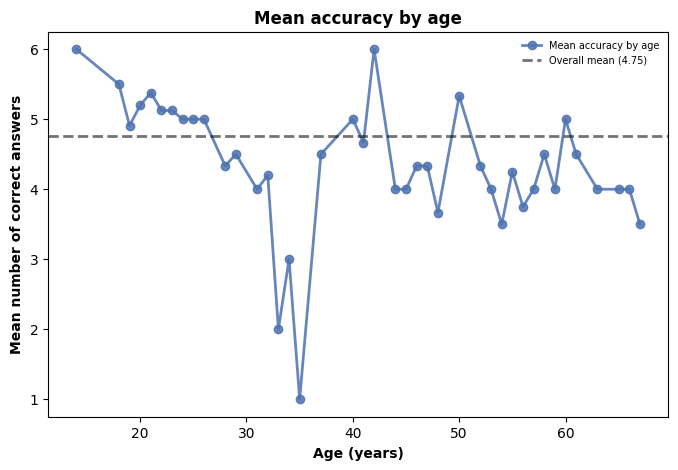

In [20]:
# overall accuracy vs age

# please use the following database variable in this part, so u do not interfere with the other parts
df_1 = database.copy()

mean_per_age = df_1.groupby("AGE")["RIGHT ANSWERS"].mean()
overall_mean = df_1["RIGHT ANSWERS"].mean()

plt.figure(figsize=(8,5))
plt.plot(mean_per_age.index, mean_per_age.values, marker="o", linewidth=2,  color="#4C72B0", alpha=0.85, label="Mean accuracy by age")
plt.axhline(overall_mean, linestyle="--", linewidth=2, color="black", label=f"Overall mean ({overall_mean:.2f})", alpha=0.55)

plt.xlabel("Age (years)", fontweight="bold")
plt.ylabel("Mean number of correct answers", fontweight="bold")
plt.title("Mean accuracy by age", fontweight="bold")
plt.legend(fontsize=7, frameon=False)
plt.show()

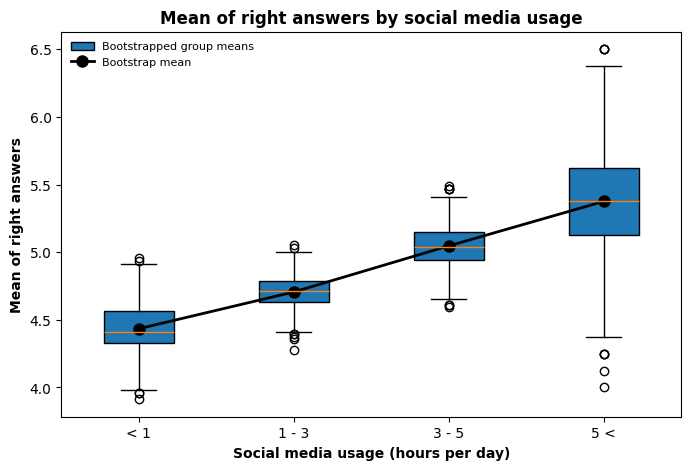

In [23]:
# overall accuracy vs social med usage
# use bootstrapping bcs the groups are uneven

# please use the following database variable in this part, so u do not interfere with the other parts
df_2 = database.copy()

order = ["Less than 1h", "1-3 hours", "3-5 hours", "5+ hours"]

bs = []
mean_per_cat = []

for group in order:
    data = df_2[df_2["SOCIAL MEDIA USAGE"] == group]["RIGHT ANSWERS"]
    means = [data.sample(n=len(data), replace=True).mean() for _ in range(1000)]
    
    bs.append(means)
    mean_per_cat.append(np.mean(means))



# plot
orders_for_plot = ["< 1", "1 - 3", "3 - 5", "5 <"]
plt.figure(figsize=(8,5))

plt.boxplot(bs, tick_labels=orders_for_plot, patch_artist=True, label="Bootstrapped group means")

for box in plt.gca().artists:
    box.set_facecolor("#4C72B0")
    
plt.plot(range(1, 5), mean_per_cat, 'ko-', linewidth=2, markersize=8, label="Bootstrap mean")

plt.xlabel("Social media usage (hours per day)", fontweight='bold')
plt.ylabel("Mean of right answers", fontweight='bold')
plt.title("Mean of right answers by social media usage", fontweight='bold')
plt.legend(fontsize=8, frameon=False, loc="upper left")
plt.show()

In [25]:
# generalized linear model, (age and usage) vs right answers (correct, incorrect)

# please use the following database variable in this part, so u do not interfere with the other parts
df_3 = database.copy()

names_mapped_to_num = {"Less than 1h": 0.5, "1-3 hours": 2, "3-5 hours": 4, "5+ hours": 6}

df_3["USAGE_HOURS"] = df_3["SOCIAL MEDIA USAGE"].map(names_mapped_to_num)

glm = sm.GLM(np.column_stack([df_3["RIGHT ANSWERS"], len(right_answers) - df_3["RIGHT ANSWERS"]]), # target
             sm.add_constant(df_3[["AGE", "USAGE_HOURS"]]), # X
             family=sm.families.Binomial()).fit()

print(glm.summary())

# meaningful col: AGE            -0.0173      0.004     -4.231      0.000      -0.025      -0.009
# -0.0173 is a coefficient that explains how the accuracy behaves as the age grows, rather than showing only the correlation# and P < 0.001 means it is a meaningful result, confirming the 1st graph
# unfortunately, no meaningful result for usage hour

                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                  200
Model:                            GLM   Df Residuals:                      197
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -301.05
Date:                Mon, 12 Jan 2026   Deviance:                       175.11
Time:                        19:55:42   Pearson chi2:                     160.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1214
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.3026      0.222      5.863      